In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

## Generator


MNIST 필기체 숫자 데이터를 이용하는 경우, 사람이 봤을 때 실제 숫자로 보이는 패턴을 학습하고 생성

64x64x256의 이미지를 생성하는 경우 총 256^4096(64x64)개의 패턴이 존재하고, 그 중 필기체 숫자처럼 보이는 패턴의 규칙을 생성자가 학습. 

생성자는 규칙(학습한 네트워크의 파라미터)과 입력 noise를 이용하여 이미지를 생성.

**전치 합성곱**

feature map up-sampling (채널을 줄이면서, 너비와 높이는 증가)

Kernel을 사용하지 않고 단순히 이미지의 크기를 늘려 셀 사이를 함수로 보완하는 F.interpolate와 달리, Kernel을 사용하여 보다 정교하고 복잡한 확대 처리를 수행. 

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        # 채널 수를 줄여나가는 방식
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size* 8 ),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                 kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                 kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                                 kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        # image_size 크기의 흑백 이미지 생성
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1,
                                 kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

Input noise : torch.Size([1, 20, 1, 1])
Generated image : torch.Size([1, 1, 64, 64])


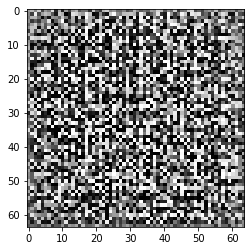

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
print('Input noise :', input_z.shape)

fake_images = G(input_z)
print('Generated image :', fake_images.shape)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## Discriminator

LeakyReLU : D의 역전파에서 손실 오차의 gradient를 G까지 전달할 수 있게 함

ReLU의 경우 입력이 음수면 출력이 0 -> 오차 역전파 중단 (학습에 유의미한 gradient를 제공할 수 없음), ReLU 층 보다 상위층까지 역전파가 전달되지 않음

LeakyReLU는 입력이 음수여도 출력이 0이 아니기 때문에 오차 역전파가 중단되지 않음 -> D의 오차를 G까지 전달할 수 있어, G의 학습이 용이해짐

단, 하위층에서 오차를 지우듯이 하며 학습한 사항을 상위층까지 전달하기 때문에 오차의 책임을 상위층으로 떠넘기는 양상이 될 수 있음. (반드시 ReLU보다 좋은 것은 아님)





In [5]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

In [6]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
print('Input noise :', input_z.shape)
fake_images = G(input_z)
print('Generated image :', fake_images.shape)
d_out = D(fake_images)
print('Realness :', d_out.shape)

# 학습을 진행하지 않았기 때문에 진짜, 가짜를 구별할 능력이 없음 (0.5)
print(nn.Sigmoid()(d_out))

Input noise : torch.Size([1, 20, 1, 1])
Generated image : torch.Size([1, 1, 64, 64])
Realness : torch.Size([1, 1, 1, 1])
tensor([[[[0.4932]]]], grad_fn=<SigmoidBackward0>)


## Loss

아래의 코드는 모두 에러 발생 (x 미정의)

In [ ]:
mini_batch_size = 2

label_real = torch.full((mini_batch_size,), 1)
label_fake = torch.full((mini_batch_size,), 0)

# 손실 함수
criterion = nn.BCEWithLogitsLoss(reduction='mean')

d_out_real = D(x) /  x : 실제 입력 이미지

생성한 이미지에 대한 D 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# loss 계산
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

In [ ]:
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

g_loss = criterion(d_out_fake.view(-1), label_real)